In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os, math, random, re
from datetime import datetime, timedelta, date

import pandas as pd
from pandas import DataFrame, Series
import numpy as np

from scipy.sparse import lil_matrix

import pysal
import pysal.esda as esda
import pysal.esda.mapclassify as mc

import geopandas as gpd
from geopandas.tools import sjoin
import geoplot as gplt
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from util import *

# Data Loading

In [3]:
%%time
detail_data=DataFrame()
loaded_files = []
for filename in os.listdir("data/details"):
    if filename.endswith(".csv"):
        loaded_files.append(pd.read_csv("data/details/"+filename))
detail_data = pd.concat(loaded_files)
detail_data.reset_index(drop=True,inplace=True)

Wall time: 23.9 s


In [4]:
detail_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,195004,28,1445,195004,28,1445,NaN,10096222,OKLAHOMA,40.0,...,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB
1,195004,29,1530,195004,29,1530,NaN,10120412,TEXAS,48.0,...,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB
2,195007,5,1800,195007,5,1800,NaN,10104927,PENNSYLVANIA,42.0,...,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB
3,195007,5,1830,195007,5,1830,NaN,10104928,PENNSYLVANIA,42.0,...,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB
4,195007,24,1440,195007,24,1440,NaN,10104929,PENNSYLVANIA,42.0,...,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB


# Convert the Time related strings to a DateTime column

In [5]:
%%time
# Pad the "DAY" columns to length 2 so the date parser can do it's thing
detail_data.BEGIN_DAY = detail_data.BEGIN_DAY.map(str).str.pad(2,fillchar='0')
detail_data.END_DAY = detail_data.END_DAY.map(str).str.pad(2,fillchar='0')
# ditto with the Time
detail_data.BEGIN_TIME = detail_data.BEGIN_TIME.map(str).str.pad(4,fillchar='0')
detail_data.END_TIME = detail_data.END_TIME.map(str).str.pad(4,fillchar='0')
# create a new column by concating the three date/time related columns and convert the result to a datetime
detail_data['BEGIN_DATE']=detail_data.BEGIN_YEARMONTH.map(str)+" "+detail_data.BEGIN_DAY.map(str)+" "+detail_data.BEGIN_TIME.map(str)
detail_data.BEGIN_DATE=pd.to_datetime(detail_data.BEGIN_DATE, format='%Y%m %d %H%M', errors='coerce')

detail_data['END_DATE']=detail_data.END_YEARMONTH.map(str)+" "+detail_data.END_DAY.map(str)+" "+detail_data.END_TIME.map(str)
detail_data.END_DATE=pd.to_datetime(detail_data.END_DATE, format='%Y%m %d %H%M', errors='coerce')

# drop the old columns
detail_data = detail_data.drop(['BEGIN_YEARMONTH', "END_YEARMONTH",'BEGIN_DAY', "END_DAY", "BEGIN_TIME", "END_TIME"], axis=1)
detail_data = detail_data.drop(['YEAR', "MONTH_NAME",'END_DATE_TIME', "BEGIN_DATE_TIME"], axis=1)

# Columns I don't think I need at the momment
detail_data = detail_data.drop(['WFO', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION','EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'], axis=1)

# columns I'm less sure I don't need, but it'll make things easier for the time being
detail_data = detail_data.drop(['INJURIES_DIRECT',
       'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS'], axis=1)

Wall time: 29.2 s


# Correcting input errors
There's some input errors with the Lat/Long coordinates - decimal place is just shifted, so dividing those by ten gives us the correct value (Affects 2080 rows)

In [6]:
detail_data.columns

Index(['EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS', 'EVENT_TYPE',
       'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'CZ_TIMEZONE', 'BEGIN_LAT',
       'BEGIN_LON', 'END_LAT', 'END_LON', 'BEGIN_DATE', 'END_DATE'],
      dtype='object')

In [7]:
detail_data.loc[detail_data.BEGIN_LON < -180, 'BEGIN_LON']=detail_data.loc[detail_data.BEGIN_LON < -180, 'BEGIN_LON']/10
detail_data.loc[detail_data.END_LON < -180, 'END_LON']=detail_data.loc[detail_data.END_LON < -180, 'END_LON']/10

Fix inconsistencies in event type tagging

In [8]:
detail_data.loc[detail_data.EVENT_TYPE.isin(['HAIL FLOODING', 'HAIL/ICY ROADS']), 'EVENT_TYPE'] = 'Hail'
detail_data.loc[detail_data.EVENT_TYPE.isin(['Heavy Wind']), 'EVENT_TYPE'] = 'High Wind'
detail_data.loc[detail_data.EVENT_TYPE.isin(['High Snow']), 'EVENT_TYPE'] = 'Heavy Snow'
detail_data.loc[detail_data.EVENT_TYPE.isin(['High Snow']), 'EVENT_TYPE'] = 'Heavy Snow'
detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'TORNADOES, TSTM WIND, HAIL',
        'THUNDERSTORM WINDS/FLOODING',
        'THUNDERSTORM WINDS/FLASH FLOOD',
        'THUNDERSTORM WINDS LIGHTNING',
        'THUNDERSTORM WIND/ TREES',
        'THUNDERSTORM WIND/ TREE',
        'THUNDERSTORM WINDS FUNNEL CLOU',
        'THUNDERSTORM WINDS/HEAVY RAIN',
        'THUNDERSTORM WINDS HEAVY RAIN',
        'THUNDERSTORM WINDS/ FLOOD'
    ]
), 'EVENT_TYPE'] = 'Thunderstorm Wind'
detail_data.loc[detail_data.EVENT_TYPE.isin(['TORNADO/WATERSPOUT']), 'EVENT_TYPE'] = 'Tornado'
detail_data.loc[detail_data.EVENT_TYPE.isin(['Landslide']), 'EVENT_TYPE'] = 'Debris Flow'
detail_data.loc[detail_data.EVENT_TYPE.isin(['Volcanic Ashfall']), 'EVENT_TYPE'] = 'Volcanic Ash'

Drop 14 rows tagged "Northern Lights" and a single row tagged 'OTHER'.

In [9]:
detail_data.drop(detail_data[detail_data.EVENT_TYPE.isin(['Northern Lights', 'OTHER'])].index, inplace=True)

# Trim the data to just the Continental US

In [10]:
detail_data = detail_data[
        ((detail_data.BEGIN_LON > -124.7844079) &
        (detail_data.BEGIN_LON < -66.9513812) &
        (detail_data.BEGIN_LAT > 24.7433195) &
        (detail_data.BEGIN_LAT < 49.3457868)) |
        (detail_data.BEGIN_LAT.isnull())
    ].copy()

# Create Categorical Index

Create two categories - one based off of the event type and another based on my not very scientific classification

In [11]:
detail_data.EVENT_TYPE = detail_data.EVENT_TYPE.astype("category")
detail_data['EVENT_CODE'] = detail_data.EVENT_TYPE.cat.codes

In [12]:
detail_data['META_TYPE'] = None
detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Avalanche',
        'Blizzard',
        'Cold/Wind Chill',
        'Extreme Cold/Wind Chill',
        'Freezing Fog',
        'Frost/Freeze',
        'Hail',
        'Heavy Snow',
        'Ice Storm',
        'Lake-Effect Snow',
        'Marine Hail',
        'Sleet',
        'Winter Storm',
        'Winter Weather'
    ]
), 'META_TYPE'] = 'Cold'

detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Dense Smoke',
        'Drought',
        'Excessive Heat',
        'Heat',
        'Volcanic Ash',
        'Wildfire'
    ]
), 'META_TYPE'] = 'Heat'

detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Debris Flow',
        'Dense Fog',
        'Lightning',
        'Marine Dense Fog',
        'Marine Lightning'
    ]
), 'META_TYPE'] = 'Other'

detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Astronomical Low Tide',
        'Coastal Flood',
        'Flash Flood',
        'Flood',
        'Heavy Rain',
        'High Surf',
        'Lakeshore Flood',
        'Rip Current',
        'Seiche',
        'Sneakerwave',
        'Storm Surge/Tide',
        'Tsunami',
        'Waterspout'
    ]
), 'META_TYPE'] = 'Water'

detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Dust Devil',
        'Dust Storm',
        'Funnel Cloud',
        'High Wind',
        'Hurricane',
        'Hurricane (Typhoon)',
        'Marine High Wind',
        'Marine Hurricane/Typhoon',
        'Marine Strong Wind',
        'Marine Thunderstorm Wind',
        'Marine Tropical Depression',
        'Marine Tropical Storm',
        'Strong Wind',
        'Thunderstorm Wind',
        'Tornado',
        'Tropical Depression',
        'Tropical Storm'
    ]
), 'META_TYPE'] = 'Wind'
detail_data.META_TYPE = detail_data.META_TYPE.astype("category")
detail_data['META_CODE'] = detail_data.META_TYPE.cat.codes

# Fill in missing data
The US Census Gazetteer contains a file which provides Lat/Long for every county in the US. Combined with the FIPs codes, we can give estimated locations for events with no clear starting point (about 1/3 of the dataset - things like "drought" or "Strong Wind" that don't have a clearly defined geographic location).
Dataset from https://www.census.gov/geo/maps-data/data/gazetteer2017.html

In [13]:
county_df = pd.read_csv('data/2017_Gaz_counties_national.txt', sep='\t', engine='python')
county_df['FIPS'] = county_df['GEOID'].apply(lambda x: '{0:0>5}'.format(x))
county_df.set_index("FIPS", inplace=True)
county_df.head(3)

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
FIPS,,,,,,,,,,
01001,AL,1001,161526,Autauga County,1539614693,25744269,594.449,9.940,32.532237,-86.646440
01003,AL,1003,161527,Baldwin County,4117605847,1133109409,1589.817,437.496,30.659218,-87.746067
01005,AL,1005,161528,Barbour County,2292144656,50538698,885.002,19.513,31.870253,-85.405104


### Fill in Lat/Lon for events based on county centroid
Create a new column that combines the State and County FIPS so we can look them up (gets coordinates for ~250k entries)

In [14]:
detail_data['FIPS'] = detail_data['STATE_FIPS']*1000+detail_data['CZ_FIPS']
detail_data['FIPS'].fillna(0, inplace=True)
detail_data['FIPS'] = detail_data['FIPS'].apply(lambda x: '{0:0>5}'.format(int(x)))

# drop the old columns, since we've condensed that data into one column
detail_data = detail_data.drop(['EPISODE_ID', 'EVENT_ID', 'STATE_FIPS', 'CZ_TYPE', 'CZ_FIPS', 'CZ_TIMEZONE'], axis=1)

Try to match up FIPS ids for events with no location info, and fill in the begin lat/lon with that counties centroid

In [15]:
# temporaily assing FIPS as the index
detail_data.set_index("FIPS", inplace=True)

# left join on the county dataframe to get a column of county centroids
detail_data = detail_data.join(county_df[['INTPTLAT', 'INTPTLONG']], on="FIPS")

# reset the index to avoid duplicate issues in a sec 
detail_data.reset_index(inplace=True)

# if the lat/lon are blank, and we were able to match it to a FIPS code, add the country centroid as the event lat/lon
detail_data.loc[detail_data.BEGIN_LAT.isnull(), 'BEGIN_LAT'] = detail_data.INTPTLAT
detail_data.loc[detail_data.BEGIN_LON.isnull(), 'BEGIN_LON'] = detail_data.INTPTLONG

#drop the extra columns now that we don't need them
detail_data.drop(['INTPTLAT', 'INTPTLONG'], axis=1, inplace=True)

### Fill in missing Date Entries
Some entries have an end date but no starting date. We're just going to fill in the latter with the former (~110k entries)

In [16]:
detail_data.loc[detail_data.BEGIN_DATE.isnull(), 'BEGIN_DATE'] = detail_data.END_DATE

In [17]:
# redundant after all the date messing earlier, but these turn out to be real handy
detail_data['MONTH'] = detail_data.BEGIN_DATE.dt.month
detail_data['DAY'] = detail_data.BEGIN_DATE.dt.day

TODO: look at filling in the remaining missing points with bp02oc18.dbx from https://www.weather.gov/gis/ZoneCounty

### Drop rows without enough data to do anything with

In [18]:
detail_data = detail_data.drop(detail_data[
    (detail_data.BEGIN_LON.isnull()) |
    (detail_data.BEGIN_LAT.isnull()) |
    (detail_data.BEGIN_DATE.isnull())
].index)

# Create the matricies and Plotting

In [19]:
# get a matrix based on a given data and a +/- date span on eithe side
def get_day_matrix(date,span=30,meta_type=None,event_type=None,coords=None,coord_range=None):
    data_set = []
    for year in range(1950,2017):
        # set the year in the date
        date = date.replace(year=year)

        # set the start and end based on the 
        start = date - timedelta(days=span)
        end = date + timedelta(days=span)
        
        
    
        year_data = detail_data[
            (detail_data.BEGIN_DATE>pd.to_datetime(start)) &
            (detail_data.BEGIN_DATE<pd.to_datetime(end))
        ]
        if meta_type is not None:
            year_data = year_data[(detail_data.META_TYPE == meta_type)]
        if event_type is not None:
            year_data = year_data[(detail_data.EVENT_TYPE == event_type)]
            
        if coords is not None:
            year_data = year_data[
                (year_data.BEGIN_LAT > coords[0]-coord_range) &
                (year_data.BEGIN_LAT < coords[0]+coord_range) &
                (year_data.BEGIN_LON > coords[1]-coord_range) &
                (year_data.BEGIN_LON < coords[1]+coord_range)
            ]
                
        data_set.append(year_data)

    data = pd.concat(data_set)

    m = lil_matrix((5783,2760), dtype=np.float16)

    for i, row in data.iterrows():
        # calculate the discount applied to the matrix value based on how many days off we are
        date = date.replace(year=row.BEGIN_DATE.year)
        days_off = abs((row.BEGIN_DATE-date).days)
        if days_off == 0:
            mat_val = 1
        else:
            mat_val = 1/(1+math.log(days_off))

        # is this a single point event or a line
        if pd.isnull(row.END_LAT) or pd.isnull(row.END_LON):
            # single point - plot a square
            col_id = lat_to_index(row.BEGIN_LAT)
            row_id = lon_to_index(row.BEGIN_LON)
            for r in range(row_id-3, row_id+4):
                for c in range(col_id-3, col_id+4):
                    try:
                        m[r,c] += mat_val
                    except:
                        print("bad row:",row)
        else:
            # we have a start and an end, so it's a line
            start = (lat_to_index(row.BEGIN_LAT),lon_to_index(row.BEGIN_LON))
            end = (lat_to_index(row.END_LAT),lon_to_index(row.END_LON))
            for pos in bresenham_line(start,end):
                try:
                    m[pos[1],pos[0]] += mat_val
                except:
                    print("bad row (line):",pos)
    return m

# Examples:
#
# get_day_matrix(
#     datetime.strptime('11/15/18', '%m/%d/%y'),
#     event_type="Dense Fog"
# )

# get_day_matrix(
#     date, 
#     span=30, 
#     meta_type="Cold", 
#     event_type=None,
#     coords=coords,
#     coord_range=2.5
# )

In [20]:
# creates a Geopandas Dataframe from the matrix output of get_day_matrix
def create_geopandas_from_matrix(m):
    # get the row and col arrays from the non zero elements of the matrix
    row,col = m.nonzero()
    # iterate through the arrays and convert them to their lat/lon approximations
    data=[]
    for x in range(len(row)):
        data.append({
            "lat":index_to_lat(col[x]),
            "lon":index_to_lon(row[x]),
            "x":m[row[x],col[x]]
        })
    # create a pandas dataframe from the data, then convert it to a geopandas dataframe
    data = DataFrame(data)
    if len(data) > 0:
        data['Coordinates'] = list(zip(data.lon, data.lat))
        data['Coordinates'] = data['Coordinates'].apply(Point)
        return gpd.GeoDataFrame(data, geometry='Coordinates')
    else:
        return None

# Plotting

load in the us state map (from https://www.arcgis.com/home/item.html?id=b07a9393ecbd430795a6f6218443dccc)

In [21]:
def get_state_shapemap():
    us_map = gpd.read_file("data/states_shape/states.shp")
    return us_map[~us_map.STATE_NAME.isin(['Hawaii',"Alaska"])].copy()

load in the us county map (from https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html)

In [22]:
def get_county_shapemap():
    us_county_map = gpd.read_file("data/shape/us_counties/cb_2017_us_county_500k.shp")
    us_county_map.STATEFP = us_county_map.STATEFP.astype(int)
    # constrain the county map to the continental us
    return us_county_map[
        (us_county_map.STATEFP<60) &
        (us_county_map.STATEFP!=2) &
        (us_county_map.STATEFP!=15)
    ]

In [23]:
# create the distance weights
wq = pysal.weights.DistanceBand.from_dataframe(get_county_shapemap(), threshold=3)
# weigh each county based on the total number of bordering counties
wq.transform = 'r'

In [ ]:
%%time
#DEMO PLOT - County plot by straight count
date = datetime.strptime('04/15/18', '%m/%d/%y')
m = get_day_matrix(date, span=10, event_type="Tornado")
data = create_geopandas_from_matrix(m)

us_county_map = get_county_shapemap()

data.crs = us_county_map.crs
county_data = sjoin(data, us_county_map, how='left')
us_county_map.set_index("GEOID", inplace=True)
us_county_map['counts'] = county_data.groupby("GEOID")['x'].sum()
us_county_map.counts.fillna(0, inplace=True)

ax = us_county_map.plot(column="counts", figsize=(5,5))

# We can now plot our GeoDataFrame.
plt.title("Points Condensed into Counties")
plt.show()

In [25]:
# make a gettis ord g plot provided a dataframe from 'create_geopandas_from_matrix(m)'
def make_gettis_ord_g_plot(data, title="Gettis Ord G* Autocorrelation", filename=None, color_map="GnBu", ret_values=False):
    # get the county shapemap
    us_county_map = get_county_shapemap()

    # join all of the data into the county dataframe
    data.crs = us_county_map.crs
    county_data = sjoin(data, us_county_map, how='left')
    us_county_map.set_index("GEOID", inplace=True)
    us_county_map['counts'] = county_data.groupby("GEOID")['x'].sum()
    us_county_map.counts.fillna(0, inplace=True)
    
    # calculate the gettis ord gi of each county based on the data
    us_county_map['counts_g_local'] = esda.getisord.G_Local(us_county_map['counts'], wq, permutations=5).Zs

    # plot the result
    f, ax = plt.subplots(1, figsize=(20,20))
    us_county_map.plot(column='counts_g_local', cmap=color_map, linewidth=0.1, ax=ax, edgecolor='black')
    ax.set_axis_off()
    
    # If there's a filename, just save it, if not, plot it to the notebook
    plt.title(title)
    if filename is not None:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()
        
    # in case I want to get the results back
    if ret_values:
        return us_county_map

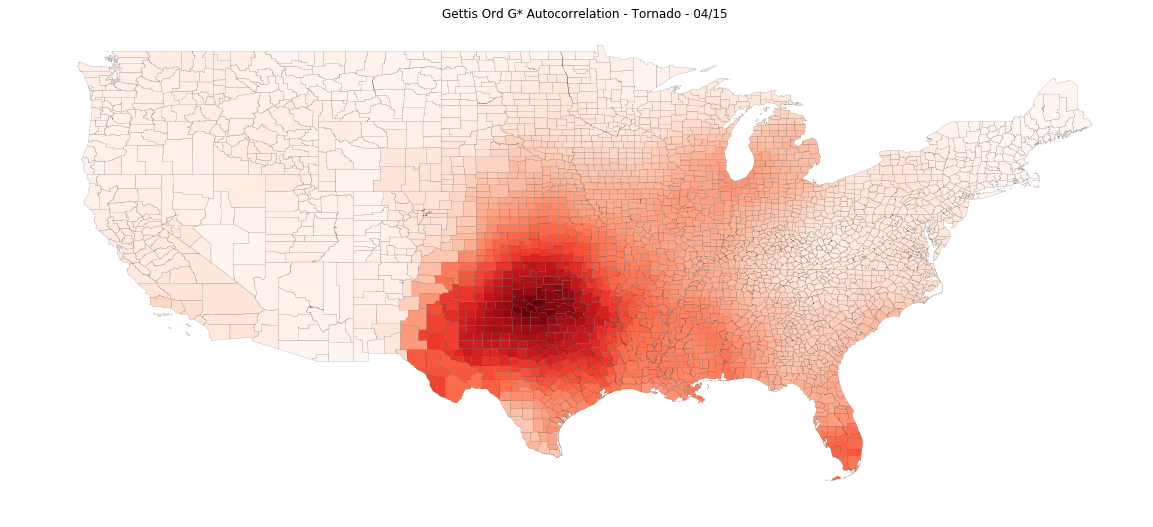

Wall time: 18.9 s


In [33]:
%%time
make_gettis_ord_g_plot(data, title="Gettis Ord G* Autocorrelation - Tornado - 04/15", color_map="Reds")

In [34]:
# get just the getti ord gi score for a given dataframe from 'create_geopandas_from_matrix(m)'
def get_gettis_ord_g_scores(data):
    # get the county shapemap
    us_county_map = get_county_shapemap()

    # join all of the data into the county dataframe
    data.crs = us_county_map.crs
    county_data = sjoin(data, us_county_map, how='left')
    us_county_map.set_index("GEOID", inplace=True)
    us_county_map['counts'] = county_data.groupby("GEOID")['x'].sum()
    us_county_map.counts.fillna(0, inplace=True)
    
    return esda.getisord.G_Local(us_county_map['counts'], wq, permutations=5).Zs

In [ ]:
%%timeit
get_gettis_ord_g_scores(data)

# Create Gettis Ord Gi Dataframes

In [ ]:
def get_spatial_lag_quartiles(data, title="Spatial Lag Median Risk Quartiles", filename=None, color_map="GnBu", ret_values=False):
    us_county_map = get_county_shapemap()

    data.crs = us_county_map.crs
    county_data = sjoin(data, us_county_map, how='left')
    us_county_map.set_index("GEOID", inplace=True)
    us_county_map['counts'] = county_data.groupby("GEOID")['x'].sum()
    us_county_map.counts.fillna(0, inplace=True)

    # create a list of counties and all the counties that county borders from the geometry of the shape file
    # wq = pysal.weights.Queen.from_dataframe(us_county_map)
    wq = pysal.weights.DistanceBand.from_dataframe(us_county_map, threshold=2, binary=True)
    # weigh each county based on the total number of bordering counties
    wq.transform = 'r'

    # get the spatial lag for each county - based on all of the attrubute values we see in neighboring counties
    y = us_county_map['counts']
    ylag = pysal.weights.lag_spatial(wq,y)

    f, ax = plt.subplots(1, figsize=(20,20))
    us_county_map.assign(cl=ylag).plot(column='cl', categorical=True,
            k=5, cmap=color_map, linewidth=0.1, ax=ax,
            edgecolor='black')
    ax.set_axis_off()
    
    plt.title(title)
    if filename is not None:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()
    
    if ret_values:
        return us_county_map.assign(cl=ylag)
    

In [ ]:
# restricting predictions to these types at the moment
event_types = ['Blizzard', 'Extreme Cold/Wind Chill', 'Hail', 'Heavy Snow', 'Ice Storm', 'Winter Storm','Drought', 
    'Excessive Heat', 'Wildfire', 'Flash Flood', 'Heavy Rain', 'High Wind', 'Hurricane', 'Thunderstorm Wind', 'Tornado']

In [ ]:
# running overnight - tack on the others to run after the main ones
# event_types = event_types + [e for e in detail_data.EVENT_TYPE.unique() if e not in event_types]

In [ ]:
%%time

for event_type in event_types:
    date = datetime.strptime('01/01/18', '%m/%d/%y')
    # set up the county data 
    county_data = get_county_shapemap()
    county_data.set_index("GEOID", inplace=True)
    
    while date.year<2019:
        print("Plotting {} - {}".format(event_type, str(date).split()[0]))

        # make a matrix for this day, using events +/- 2 weeks
        m = get_day_matrix(date, span=14, event_type=event_type)
        # throw that data into a geopandas frame
        data = create_geopandas_from_matrix(m)
        if data is None:
            print("No data found for", date)
            county_data["{}-{:%m-%d}_g_score".format(re.sub(r'\W+', '', event_type), date)] = 0
        else:
            vals = get_gettis_ord_g_scores(data)
            county_data["{}-{:%m-%d}_g_score".format(re.sub(r'\W+', '', event_type), date)] = vals

        date = date + timedelta(days=7)        
    # save it
    county_data.to_file("output/{}_weekly_g_score.geoJSON".format(re.sub(r'\W+', '', event_type)))

# Make Predictions

In [35]:
# restricting predictions to these types at the moment
event_types = ['Blizzard', 'Extreme Cold/Wind Chill', 'Hail', 'Heavy Snow', 'Ice Storm', 'Winter Storm','Drought', 
    'Excessive Heat', 'Wildfire', 'Flash Flood', 'Heavy Rain', 'High Wind', 'Hurricane', 'Thunderstorm Wind', 'Tornado']

Getting labeled events

In [36]:
# super simple - find an event at random that occured after 2016
def get_positive_event():  
    event = detail_data[detail_data.BEGIN_DATE > '2016-01-01'].sample()
    return event.EVENT_TYPE.values[0], event.META_TYPE.values[0], (event.BEGIN_LAT.values[0], event.BEGIN_LON.values[0]), event.BEGIN_DATE.values[0]

In [37]:
# trickier - we need to pick a location and date at random, then check to make sure nothing happened 
# if it did, we guess again until we come up with nothing
def get_negative_event(max_range=1.5, day_range=10):
    event_count = 99
    event_type = random.choice(event_types)
    while event_count != 0:
        event_count = 0
        # guess a random lat/long combo in the continental us
        lat = random.uniform(24.7433195, 49.3457868)
        lon = random.uniform(-124.7844079, -66.9513812)
        
        # guess a random date (days from 1-28 so I don't have to worry about Feb)
        search_date = datetime(year=2016, month=random.randint(1,12), day=random.randint(1,28))
        
        # get all events from the dataset withing +/- max_range of that location
        nearby_events = detail_data[
            ((detail_data.BEGIN_LON > lon-max_range) &
            (detail_data.BEGIN_LON < lon+max_range) &
            (detail_data.BEGIN_LAT > lat-max_range) &
            (detail_data.BEGIN_LAT < lat+max_range)) &
            (detail_data.EVENT_TYPE==event_type)
        ].copy()
        
        # check every year in the dataset and count how many hits we get
        # TODO: There's got to be a simpler way of doing this
        for year in range(1950, 2017):
            search_date = search_date.replace(year=year)
            event_count += len(nearby_events[
                ((nearby_events.BEGIN_DATE >= (search_date - timedelta(days=day_range))) &
                (nearby_events.BEGIN_DATE <= (search_date + timedelta(days=day_range))))
            ])
#         print("{} {} events at ({},{}) within {} days of {}".format(event_count, event_type, lat, lon, day_range, search_date))
    return event_type, "", (lat, lon), search_date

In [38]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

Prediction Approach #1

In [39]:
rolling = 7
threshold = 0.01

def predict(event_type, coords, date):
    # load in the geopandas file with the g scores
    data_g_scores = gpd.read_file("output/{}_weekly_g_score.geoJSON".format(re.sub(r'\W+', '', event_type)))
    
    # get the data for the specific county these coordinates fall in 
    county_level_data = data_g_scores[data_g_scores.geometry.contains(Point(coords[1],coords[0]))]
    
    # not sure whey this is happening
    if len(county_level_data) == 0:
        return False, 0
    
    # screwy, but this works. Get an array of values by week
    county_data = county_level_data.iloc[:,8:-1].transpose().iloc[:,0].values
    
    week_of_year = date.isocalendar()[1]
    value = running_mean(county_data, rolling)[week_of_year]
    
    return value > threshold, value

In [ ]:
%%time
tries = 100
results = []

# check positive events
for x in range(tries):
    event_type = ""
    while event_type not in event_types:
        event_type, meta_type, coords, date = get_positive_event()
    # from https://stackoverflow.com/a/29753985
    date = datetime.utcfromtimestamp(date.tolist()/1e9)
    try:
        prediction = predict(event_type, coords, date)
        results.append({
            "truth":True,
            "prediction":prediction[0],
            "p_value":prediction[1],
            "event_type":event_type,
            "coords":coords,
            "date":date
        })
    except:
        print("ERR (POS):",event_type, coords, date)

# check negative events
for x in range(tries):
    event_type = ""
    while event_type not in event_types:
        event_type, meta_type, coords, date = get_negative_event()
    try:
        prediction = predict(event_type, coords, date)
        results.append({
            "truth":False,
            "prediction":prediction[0],
            "p_value":prediction[1],
            "event_type":event_type,
            "coords":coords,
            "date":date
        })
    except:
        print("ERR (NEG):",event_type, coords, date)

Prediction Approach #2

In [ ]:
day_range=21
max_range=1.5
threshold = 0.75

results = []

conf={"tt":0, "tf":0, "ft":0, "ff":0}

for x in range(3):
    lat = random.uniform(24.7433195, 49.3457868)
    lon = random.uniform(-124.7844079, -66.9513812)
    correct = 0
    print(x)

    
    for event_type in event_types:
        try:
            likely = True

            data_g_scores = gpd.read_file("output/{}_weekly_g_score.geoJSON".format(re.sub(r'\W+', '', event_type)))

            # get the data for the county from this data set
            county_level_data = data_g_scores[data_g_scores.geometry.contains(Point(lon,lat))]

            # screwy, but gets us a week number for our predictions
            county_level_data = county_level_data.iloc[:,9:-1].transpose()
            county_level_data.columns = ['value']
            county_level_data.reset_index(inplace=True)
            predicted_weeks = county_level_data.sort_values("value", ascending=False).head(2).index.values

            max_like = county_level_data.sort_values("value", ascending=False).head(1).value.values[0]
            if max_like < threshold:
                likely=False

            # derive a date from the sunday of that week we can use to search
            search_date = datetime.strptime("2017-W{}".format(predicted_weeks[0]) + '-0', "%Y-W%W-%w")

            # filter the detail data down by distance and date to see if any of this kind of event are within our window
            prediction_set = detail_data[
                        ((detail_data.BEGIN_LON > lon-max_range) &
                        (detail_data.BEGIN_LON < lon+max_range) &
                        (detail_data.BEGIN_LAT > lat-max_range) &
                        (detail_data.BEGIN_LAT < lat+max_range)) &
                        (detail_data.EVENT_TYPE==event_type)
                    ].copy()

            prediction_set = prediction_set[
                (prediction_set.BEGIN_DATE >= (search_date - timedelta(days=day_range))) &
                (prediction_set.BEGIN_DATE <= (search_date + timedelta(days=day_range)))
            ]

            if (len(prediction_set) > 0 and likely) or (len(prediction_set) == 0 and not likely):
                if len(prediction_set) > 0 and likely: conf['tt'] += 1
                else: conf['ff'] += 1
                    
                correct += 1
                print("Succcess - {} near {} on {} (Guess:{})".format(event_type, (lat,lon), search_date, likely))
            else:
                if likely: conf['tf'] += 1
                else: conf['ft'] += 1
                    
                print("Fail - {} near {} on {} (Guess:{})".format(event_type, (lat,lon), search_date, likely))
                pass
        except:
            continue

    print("Total Correct:{}/{}".format(correct,len(event_types)))
    results.append({
        "lat":lat,
        "lon":lon,
        "correct":correct
    })

# Old Code I don't want to throw away
But I probably should

In [ ]:
# Get a matrix based on the start and end dates provided
# can also specift a meta type or an event type
def get_matrix(start, end, meta_type=None, event_type=None):
    if meta_type is None and event_type is None:
        # filter the detail data by those two dates and add it to the set
        data = detail_data[
            (detail_data.BEGIN_DATE>pd.to_datetime(start)) &
            (detail_data.BEGIN_DATE<pd.to_datetime(end))
        ]
    else:
        if meta_type is not None:
            data = detail_data[
                (detail_data.BEGIN_DATE>pd.to_datetime(start)) &
                (detail_data.BEGIN_DATE<pd.to_datetime(end)) &
                (detail_data.META_TYPE == meta_type)
            ]
        elif event_type is not None:
            data = detail_data[
                (detail_data.BEGIN_DATE>pd.to_datetime(start)) &
                (detail_data.BEGIN_DATE<pd.to_datetime(end)) &
                (detail_data.EVENT_TYPE == event_type)
            ]

    m = lil_matrix((5783,2760), dtype=np.float16)

    for i, row in data.iterrows():
        mat_val = 1


        # is this a single point event or a line
        if pd.isnull(row.END_LAT) or pd.isnull(row.END_LON):
            # single point - plot a square
            col_id = lat_to_index(row.BEGIN_LAT)
            row_id = lon_to_index(row.BEGIN_LON)
            for r in range(row_id-3, row_id+4):
                for c in range(col_id-3, col_id+4):
                    try:
                        m[r,c] += mat_val
                    except:
                        print("bad row:",row)
        else:
            # we have a start and an end, so it's a line
            start = (lat_to_index(row.BEGIN_LAT),lon_to_index(row.BEGIN_LON))
            end = (lat_to_index(row.END_LAT),lon_to_index(row.END_LON))
            for pos in bresenham_line(start,end):
                try:
                    m[pos[1],pos[0]] += mat_val
                except:
                    print("bad row (line):",pos)
    return m

In [ ]:
def get_year_month_matrix(year, month):
    start = "{:0d}-{:02d}-01".format(year, month)
    if month == 12:
        month = 1
        year += 1
    else:
        month+=1
    end = "{:0d}-{:02d}-01".format(year, month)
    year_data = detail_data[(detail_data.BEGIN_DATE>start) & (detail_data.BEGIN_DATE<end)].dropna()
    # trim it to just the continental US
    year_data = year_data[
        (year_data.BEGIN_LON > -124.7844079) &
        (year_data.BEGIN_LON < -66.9513812) &
        (year_data.BEGIN_LAT > 24.7433195) &
        (year_data.BEGIN_LAT < 49.3457868)
    ]
    m = lil_matrix((5783,2760), dtype=np.int16)
    for i, row in year_data.iterrows():
        if row.END_LAT==np.nan or row.END_LON==np.nan:
            col_id = lat_to_index(row.BEGIN_LAT)
            row_id = lon_to_index(row.BEGIN_LON)
            for r in range(row_id-3, row_id+4):
                for c in range(col_id-3, col_id+4):
                    try:
                        m[r,c] = 1
                    except:
                        print("bad row:",row)
        else:
            # we have a start and an end, so it's a line
            start = (lat_to_index(row.BEGIN_LAT),lon_to_index(row.BEGIN_LON))
            end = (lat_to_index(row.END_LAT),lon_to_index(row.END_LON))
            for pos in bresenham_line(start,end):
                try:
                    m[pos[1],pos[0]] = 1
                except:
                    print("bad row:",pos)
    return m



In [ ]:
%%time
county_data = get_county_shapemap()
county_data.set_index('GEOID', inplace=True)

start_date = datetime.strptime('01/01/1950', '%m/%d/%Y')
end_date = datetime.strptime('01/01/2019', '%m/%d/%Y')

for event_type in [x for x in detail_data.EVENT_TYPE.unique() if x not in ["Avalanche", "Blizzard", "Flash Flood", "Hail", "Thunderstorm Wind", "Tornado", "Winter Storm"]]:
    print(event_type)
    m = get_matrix(start_date, end_date, event_type=event_type)
    data = create_geopandas_from_matrix(m)
    print("Creating plots from {} entries".format(len(data)))
    val = get_spatial_lag_quartiles(
        data, 
        title="Spatial Lag Median Risk Quartiles - {}".format(event_type),
        filename="event_output/spatial_lag_quartile_{0}.png".format(event_type.replace('/',' ')),
        ret_values=True)
    county_data[event_type+"_quartile"] = val.cl
    val = get_gettis_ord_g(
        data, 
        title="Gettis Ord G* Autocorrelation - {}".format(event_type), 
        filename="event_output/gettis_ord_g_{0}.png".format(event_type.replace('/',' ')),
        ret_values=True)
    county_data[event_type+"_g_local"] = val.counts_g_local
    county_data.to_csv("county_overall_output.csv")

In [ ]:
%%time
meta_type_colors = {
    'Cold':"Blues",
    'All':"Greys",
    'Wind':"BuGn",
    'Water':"PuBu",
    'Other':"Greens",
    'Heat':"YlOrRd"
}

county_data = get_county_shapemap()
county_data.set_index("GEOID", inplace=True)

for meta_type, color_map in meta_type_colors.items():
    date = datetime.strptime('01/01/18', '%m/%d/%y')
    while date.year<2019:
        print("Plotting {} - {}".format(meta_type, str(date).split()[0]))
        if meta_type == "All":
            m = get_day_matrix(date, span=14)
        else:
            m = get_day_matrix(date, span=14, meta_type=meta_type)
        data = create_geopandas_from_matrix(m)
        if data is None:
            print("No data found for", date)
        else:
            val = get_gettis_ord_g(
                data,
                title="Gettis Ord G* Autocorrelation - {} - ({})".format(meta_type, str(date).split()[0]), 
                filename="temp.png",
                color_map=color_map,
                ret_values=True
            )
            county_data["{}-{:%m-%d}_p_sim".format(meta_type, date)] = val.counts_p_sim
            county_data.to_csv("weekly_p_sim.csv")
        date = date + timedelta(days=7)

In [ ]:
%%time

county_data = get_county_shapemap()
county_data.set_index("GEOID", inplace=True)

while date.year<2019:
    print("Plotting {} - {}".format(meta_type, str(date).split()[0]))
    m = get_day_matrix(date, span=14, event_type='Tornado')
    data = create_geopandas_from_matrix(m)
    if data is None:
        print("No data found for", date)
    else:
        val = get_gettis_ord_g(
            data,
            title="Gettis Ord G* Autocorrelation - {} - ({})".format(meta_type, str(date).split()[0]), 
            filename="temp.png",
            color_map=color_map,
            ret_values=True
        )
        county_data["{}-{:%m-%d}_p_sim".format(meta_type, date)] = val.counts_p_sim
        county_data.to_csv("tornado_p_sim.csv")
    date = date + timedelta(days=7)

In [ ]:
drought_p_sim = pd.read_csv("tornado_p_sim.csv")
drought_p_sim.set_index("GEOID", inplace=True)

In [ ]:
drought_p_sim.loc[48221][9:].astype(float).values

In [ ]:
geo_id = 29095
rolling = 4
date = datetime.strptime('01/01/18', '%m/%d/%y')
date_list = ["{:%m-%d}".format(date+timedelta(days=x)) for x in range(0, 365, 7)]

f, ax = plt.subplots(1, figsize=(20,5))
sns.lineplot(y=running_mean(drought_p_sim.loc[geo_id][9:].astype(float).values, rolling), x=date_list[:-rolling+1], palette="RdGy")

# ax.legend(['Drought Likelyhood'])

plt.xticks(rotation=90)
plt.title("Tornado Likelyhood for 39.0997° N, 94.5786° W (Kansas City, MO)")
plt.savefig("kc_plot.png")
plt.show()

In [40]:
weekly_p_sim = pd.read_csv("weekly_p_sim.csv")
weekly_p_sim.set_index("GEOID", inplace=True)

In [41]:
cold_p_sim = weekly_p_sim.iloc[:,9:62].copy()
all_p_sim = weekly_p_sim.iloc[:,62:115].copy()
wind_p_sim = weekly_p_sim.iloc[:,115:168].copy()
water_p_sim = weekly_p_sim.iloc[:,168:221].copy()
other_p_sim = weekly_p_sim.iloc[:,221:274].copy()
heat_p_sim = weekly_p_sim.iloc[:,274:327].copy()

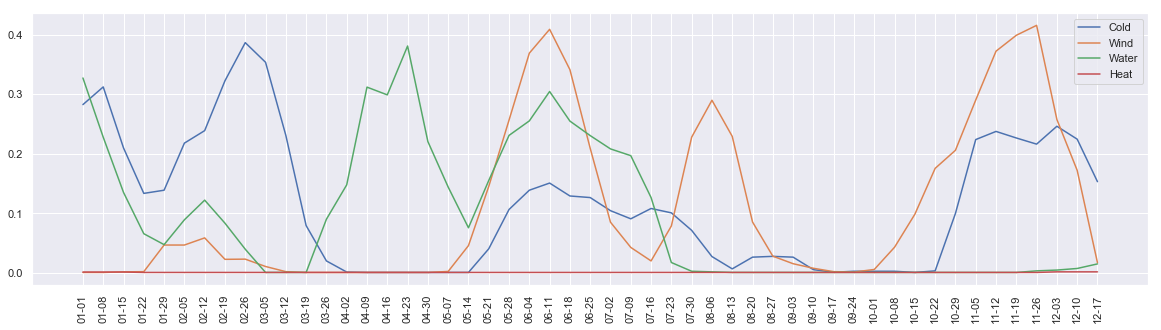

In [42]:
sns.set()
geo_id = 26161
rolling = 3
date = datetime.strptime('01/01/18', '%m/%d/%y')
date_list = ["{:%m-%d}".format(date+timedelta(days=x)) for x in range(0, 365, 7)]

f, ax = plt.subplots(1, figsize=(20,5))
sns.lineplot(y=running_mean(cold_p_sim.loc[geo_id].values, rolling), x=date_list[:-rolling+1])
sns.lineplot(y=running_mean(wind_p_sim.loc[geo_id].values, rolling), x=date_list[:-rolling+1])
sns.lineplot(y=running_mean(water_p_sim.loc[geo_id].values, rolling), x=date_list[:-rolling+1])
sns.lineplot(y=running_mean(heat_p_sim.loc[geo_id].values, rolling), x=date_list[:-rolling+1])

ax.legend(['Cold','Wind','Water','Heat'])
plt.xticks(rotation=90)

plt.savefig("aa_plot.png")
plt.show()

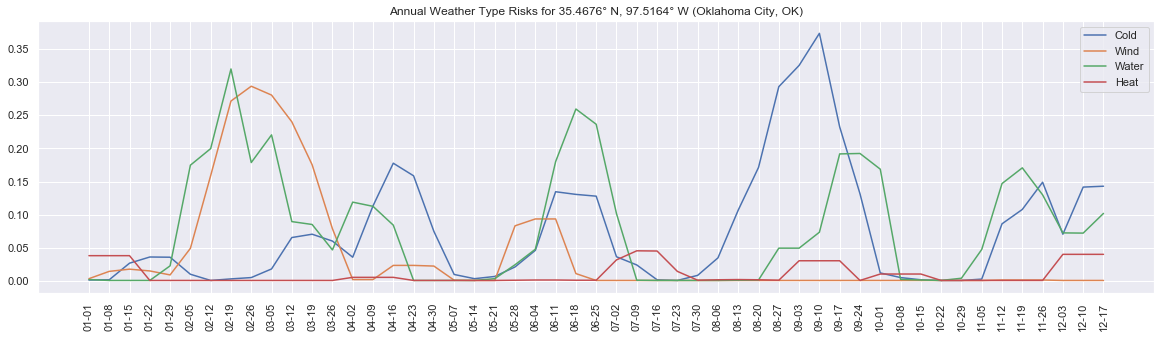

In [43]:
sns.set()
geo_id = 40109
rolling = 3
date = datetime.strptime('01/01/18', '%m/%d/%y')
date_list = ["{:%m-%d}".format(date+timedelta(days=x)) for x in range(0, 365, 7)]

f, ax = plt.subplots(1, figsize=(20,5))
sns.lineplot(y=running_mean(cold_p_sim.loc[geo_id].values, rolling), x=date_list[:-rolling+1])
sns.lineplot(y=running_mean(wind_p_sim.loc[geo_id].values, rolling), x=date_list[:-rolling+1])
sns.lineplot(y=running_mean(water_p_sim.loc[geo_id].values, rolling), x=date_list[:-rolling+1])
sns.lineplot(y=running_mean(heat_p_sim.loc[geo_id].values, rolling), x=date_list[:-rolling+1])

ax.legend(['Cold','Wind','Water','Heat'])
plt.xticks(rotation=90)
plt.title("Annual Weather Type Risks for 35.4676° N, 97.5164° W (Oklahoma City, OK)")
plt.savefig("ok_plot.png")
plt.show()

In [44]:
rolling = 5
date = datetime.strptime('01/01/18', '%m/%d/%y')
date_list = [date+timedelta(days=x) for x in range(0, 365, 7)][:-rolling+1]

In [45]:
def predict(geo_id, date):
    date = date.replace(year=2018)
    p_sims = DataFrame({
        "Cold":running_mean(cold_p_sim.loc[geo_id].values, rolling), 
        "Wind":running_mean(wind_p_sim.loc[geo_id].values, rolling),
        "Water":running_mean(water_p_sim.loc[geo_id].values, rolling),
        "Heat":running_mean(heat_p_sim.loc[geo_id].values, rolling),
        "date":date_list})

    start = date - timedelta(days=4)
    end = date + timedelta(days=4)
    predictions = p_sims[
        (p_sims.date >= start) &
        (p_sims.date <= end)
    ].mean().sort_values(ascending=False)
    
    return predictions


In [ ]:
date = datetime.strptime('05/24/18', '%m/%d/%y')
geo_id = 36111

predictions = predict(geo_id, date)